In [172]:
import numpy as np
from skimage import segmentation
from skimage.feature import local_binary_pattern
from skimage.color import rgb2hsv
from sklearn.preprocessing import normalize
from scipy.ndimage.morphology import binary_dilation



# A color histogram of 25 bins is calculated for each channel of the image
def color_hist(reg_mask, bins=25, lower_range=0.0, upper_range=255.0):
    # reg_mask.shape = (region size, channels)
    hist = []
    for channel in np.arange(reg_mask.shape[1]):
        hist.append(np.histogram(reg_mask[:, channel], bins, (lower_range, upper_range))[0])
    hist = np.concatenate(hist, axis=0)
    hist_norm = normalize(hist.reshape(1, -1), norm='l1')
    return hist_norm.ravel()

def texture_descriptor(img):
    # we use LBP (local binary pattern)
    # LBP is an invariant descriptor that can be used for texture classification
    text_img = []
    for channel in np.arange(img.shape[2]):
        text_img.append(local_binary_pattern(img[:,:,channel], 24, 3))
    return np.stack(text_img, axis=2)

def texture_hist(text_reg_mask, bins=80, lower_range=0.0, upper_range=255.0):
    # text_reg_mask.shape = (region size, channels)
    hist = []
    for channel in np.arange(text_reg_mask.shape[1]):
        hist.append(np.histogram(text_reg_mask[:, channel], bins, (lower_range, upper_range))[0])
    hist = np.concatenate(hist, axis=0)
    hist_norm = normalize(hist.reshape(1, -1), norm='l1')
    return hist_norm.ravel()

def add_prop_reg(img_and_seg, R):
    R_and_prop = R
    segments = img_and_seg[:,:,3]
    text_img = texture_descriptor(img_and_seg[:,:,:3])
    for seg in np.unique(segments):
        # color histogram
        reg_mask = img_and_seg[:, :, :3][segments == seg]
        col_hist = color_hist(reg_mask)

        # texture histogram
        text_reg_mask = text_img[segments == seg]
        text_hist = texture_hist(text_reg_mask)

        R_and_prop[seg]["col_hist"] = col_hist
        R_and_prop[seg]["text_hist"] = text_hist
    return R_and_prop

def extract_regions(img_and_seg):
    R = []
    segments = img_and_seg if len(img_and_seg.shape) == 2 else img_and_seg[:,:,3]
    for r in np.unique(segments):
        i = np.asarray(np.where(segments == r))
        x_min = i[1,:].min()
        x_max = i[1,:].max()
        y_min = i[0,:].min()
        y_max = i[0,:].max()
        width = (x_max - x_min) + 1
        height = (y_max - y_min) + 1
        size = i.shape[1]

        R.append({"x_min": x_min, "x_max": x_max, "y_min": y_min, "y_max": y_max, "width": width, "height": height, "size": size, "label": r})
    return R

def get_bb(window, label):
    i = np.asarray(np.where(window == label))
    x_min = i[1, :].min()
    x_max = i[1, :].max()
    y_min = i[0, :].min()
    y_max = i[0, :].max()
    return x_min, x_max, y_min, y_max

def find_neighbours(reg_bb, label):
    mask = np.zeros(reg_bb.shape)
    mask[np.where(reg_bb == label)] = 1
    struct = np.ones((3, 3))
    mask_dilated = binary_dilation(mask, structure=struct)
    mask[np.where(mask_dilated == False)] = reg_bb[np.where(mask_dilated == False)]
    mask[np.where(mask_dilated == True)] = label
    dif = abs(mask - reg_bb)
    neig = np.unique(reg_bb[np.where(dif != 0)]).tolist()

    return neig

def extract_neighbors(img_and_seg, regions):
    N = []  # region, neighbours
    h = img_and_seg.shape[0]  # rows
    w = img_and_seg.shape[1]  # columns
    segments = img_and_seg[:, :, 3]
    for r in regions:
        x_min = r["x_min"] - 1 if r["x_min"] != 0 else r["x_min"] # +1 padding
        x_max = r["x_max"] + 2 if r["x_max"] != w else r["x_max"] # +1 padding
        y_min = r["y_min"] - 1 if r["y_min"] != 0 else r["y_min"] # +1 padding
        y_max = r["y_max"] + 2 if r["y_max"] != h else r["y_max"] # +1 padding
        reg_bb = segments[y_min:y_max, x_min:x_max]  # region bounding box
        neig = find_neighbours(reg_bb, r["label"])
        N.append({"region": r["label"], "neig": neig})
    return N

def calc_BB(r1, r2):
    # calculate the tight bounding box around r1 and r2
    x_min_BB = min(r1["x_min"], r2["x_min"])
    x_max_BB = max(r1["x_max"], r2["x_max"])
    y_min_BB = min(r1["y_min"], r2["y_min"])
    y_max_BB = max(r1["y_max"], r2["y_max"])
    BB_size = (y_max_BB - y_min_BB) * (x_max_BB - x_min_BB)
    return x_min_BB, x_max_BB, y_min_BB, y_max_BB, BB_size

def sim_size(r1, r2, img_size):
    # calculate the size similarity over the image
    r1_size = r1['size']
    r2_size = r2['size']
    return 1.0 - ((r1_size + r2_size) / img_size)

# Color similarity of two regions is based on histogram intersection
def sim_color(r1, r2):
    hist_r1 = r1['col_hist']
    hist_r2 = r2['col_hist']
    return sum([min(a,b) for a,b in zip(hist_r1, hist_r2)])

def sim_texture(r1, r2):
    hist_r1 = r1['text_hist']
    hist_r2 = r2['text_hist']
    return sum([min(a, b) for a, b in zip(hist_r1, hist_r2)])

def sim_fill(r1, r2, img_size):
    # measure how well region r1 and r2 fit into each other
    r1_size = r1['size']
    r2_size = r2['size']
    _, _, _, _, BB_size = calc_BB(r1, r2)
    return 1.0 - ((BB_size - r1_size - r2_size) / img_size)

def calc_sim(r1, r2, img_and_seg, measure=(1,1,1,1)):
    # measure = (s, c, t, f)
    s_size, s_color, s_texture, s_fill = 0, 0, 0, 0
    img_size = img_and_seg.shape[0] * img_and_seg.shape[1]
    if measure[0]:
        s_size = sim_size(r1, r2, img_size)
    if measure[1]:
        s_color = sim_color(r1, r2)
    if measure[2]:
        s_texture = sim_texture(r1, r2)
    if measure[3]:
        s_fill = sim_fill(r1, r2, img_size)
    return (s_size + s_color + s_texture + s_fill) / np.nonzero(measure)[0].size

# calculate initial similarities
def initial_sim(img_and_seg, R, N, measure):
    S = []
    for r in N:
        r1 = [x for x in R if x['label'] == r["region"]][0]
        for n in r["neig"]:
            r2 = [x for x in R if x['label'] == n][0]
            if n > r["region"]:
                s = calc_sim(r1, r2, img_and_seg, measure=measure)
                S.append({"regions": [r["region"], n], "sim": s})
    return S

# calculate new region similarities
def new_sim(img_and_seg, R, rt, measure):
    S = []
    r1 = [x for x in R if x['label'] == rt["region"]][0]
    for n in rt["neig"]:
        r2 = [x for x in R if x['label'] == n][0]
        s = calc_sim(r1, r2, img_and_seg, measure=measure)
        S.append({"regions": [rt["region"], n], "sim": s})
    return S

def merge_regions(img_and_seg, regions, R, N):
    ri = [x for x in R if x['label'] == regions[0]][0]
    rj = [x for x in R if x['label'] == regions[1]][0]
    idx_ri = [i for i, x in enumerate(R) if x['label'] == regions[0]][0]
    idx_rj = [i for i, x in enumerate(R) if x['label'] == regions[1]][0]

    # new region rt = ri UNION rj
    img_and_seg[:, :, 3][img_and_seg[:, :, 3] == regions[1]] = regions[0]  # rt = ri + (rj = ri)
    x_min_rt, x_max_rt, y_min_rt, y_max_rt, _ = calc_BB(ri, rj)
    width_rt = (x_max_rt - x_min_rt) + 1
    height_rt = (y_max_rt - y_min_rt) + 1
    size_rt = ri["size"] + rj["size"]
    col_hist_rt = (ri["size"] * ri["col_hist"] + rj["size"] * rj["col_hist"]) / size_rt
    col_hist_rt = normalize(col_hist_rt.reshape(1, -1), norm='l1')[0]
    text_hist_rt = (ri["size"] * ri["text_hist"] + rj["size"] * rj["text_hist"]) / size_rt
    text_hist_rt = normalize(text_hist_rt.reshape(1, -1), norm='l1')[0]

    R[idx_ri]["x_min"] = x_min_rt
    R[idx_ri]["x_max"] = x_max_rt
    R[idx_ri]["y_min"] = y_min_rt
    R[idx_ri]["y_max"] = y_max_rt
    R[idx_ri]["width"] = width_rt
    R[idx_ri]["height"] = height_rt
    R[idx_ri]["size"] = size_rt
    R[idx_ri]["col_hist"] = col_hist_rt
    R[idx_ri]["text_hist"] = text_hist_rt

    # neighborhood
    idxN_ri = [i for i, x in enumerate(N) if x['region'] == regions[0]][0]
    idxN_rj = [i for i, x in enumerate(N) if x['region'] == regions[1]][0]
    N[idxN_ri]["neig"].remove(regions[1])
    N[idxN_rj]["neig"].remove(regions[0])
    for n in N[idxN_rj]["neig"]:
        if n not in N[idxN_ri]["neig"]:
            N[idxN_ri]["neig"].append(n)

        idx_n = [i for i, x in enumerate(N) if x['region'] == n][0]
        N[idx_n]["neig"].remove(regions[1])
        if regions[0] not in N[idx_n]["neig"]:
            N[idx_n]["neig"].append(regions[0])

    del R[idx_rj]
    del N[idxN_rj]

    return img_and_seg, R, N


#%%

def selective_search(image, colour_space="hsv", scale=20, measure=(1,1,1,1), sim_threshold=0.65,
                    sigma=0.8,min_size=1000):
    """
    Parameters
    ----------
    :param image: (width, height, 3) ndarray
        Input image.
    :param colour_space: {"rgb", "hsv"}
        Colour space to perform our hierarchical grouping algorithm.
    :param scale: float
        Free parameter. Higher means larger clusters in the initial segmentation (Felsenszwalb's segmentation).
    :param measure: (size, colour, texture, fill) tuple
        Define the similarity measures to use.
    :param sim_threshold: float
        Indicates the threshold of similarity between regions in range [0,1].
    Returns
    -------
    :segment_mask: (width, height) ndarray
        Ndarray with the same width and height that the input image with labeled regions.
    :regions: list
        List of dict with the properties of the regions
    """

    if colour_space == "hsv":
        image = rgb2hsv(image)
        image = image - image.min()  # min = 0
        image = image / image.max()  # max = 1
        image = image * 255
        image = image.astype(np.uint8)

    # obtain initial regions
    # return image and initial segments, shape[2] = (channel1, channel2, channel3, segments)
    img_and_seg = initial_regions(image, scale,sigma,min_size)
    print(len(np.unique(img_and_seg[:,:,3])), "initial regions")
    R = extract_regions(img_and_seg)
    R = add_prop_reg(img_and_seg, R)

    # extract neighboring regions
    N = extract_neighbors(img_and_seg, R)

    # calculate similarity
    init_S = initial_sim(img_and_seg, R, N, measure)

    # hierarchical grouping algorithm
    under_thres = False
    while under_thres == False:
        # get highest similarity
        s = [x['sim'] for x in init_S]
        max_sim = max(s or [0.0])

        if max_sim >= sim_threshold:
            regions = init_S[np.where(s == max_sim)[0][0]]["regions"]

            # merge corresponding regions
            img_and_seg, R, N = merge_regions(img_and_seg, regions, R, N)

            # remove similarities
            del_ind = []
            for i, r in enumerate(init_S):
                if any([regions[0] in r["regions"], regions[1] in r["regions"]]):
                    del_ind.append(i)
            init_S = np.delete(init_S, del_ind).tolist()

            # calculate similarity set between rt and its neighbours
            rt = [x for x in N if x['region'] == regions[0]][0]
            new_S = new_sim(img_and_seg, R, rt, measure)
            init_S = init_S + new_S
        else:
            under_thres = True

    return img_and_seg[:, :, 3], R

/tmp/ipykernel_245760/190107374.py:6: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


In [173]:
from data.byol_transform import *
import numpy as np
from model import BYOLModel
import yaml
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch import nn
from skimage.segmentation import slic
from torchvision.models._utils import IntermediateLayerGetter
from sklearn.cluster import *

In [174]:

anno = '/home/jacklishufan/ByteTrack/datasets/coco/annotations/instances_train2017.json'
image_dir="/home/jacklishufan/detconb/imagenet"
root = '/home/jacklishufan/ByteTrack/datasets/coco/train2017'
stage = 'train'
mask_type = 'fh'
transform1 = get_transform(stage)
transform2 = get_transform(stage, gb_prob=0.1, solarize_prob=0.2)
transform3 = get_transform('raw')
transform = MultiViewDataInjector([transform1, transform2,transform3],False)
image_dir_t = os.path.join(image_dir,'images', f"{'train' if stage in ('train', 'ft') else 'val'}")
mask_file = os.path.join(image_dir,'masks',stage+'_tf_img_to_'+mask_type+'.pkl')
mask_file_path = os.path.join(image_dir,'masks','train_tf')
dataset = SSLMaskDataset(image_dir_t,mask_file,transform=transform,mask_file_path=mask_file_path)

total files: 12811


In [270]:
views,masks,transforms =  dataset[102]
view1,view2,view_raw = views

In [271]:
def de_normalize(view1):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    return (view1 * torch.tensor(std).reshape(3,1,1)*255) + torch.tensor(mean).reshape(3,1,1)*255

In [272]:
torch.tensor(mean).reshape(3,1,1)

tensor([[[0.4850]],

        [[0.4560]],

        [[0.4060]]])

In [273]:
img = de_normalize(view_raw)
img = img.permute(1,2,0).int()

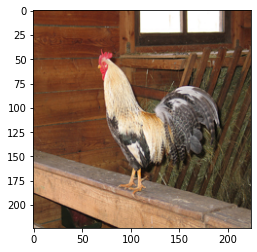

In [274]:
plt.imshow(img)

In [275]:
def initial_regions(image, scale,sigma,min_size):
    init_segments = segmentation.felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size)
    #init_segments=slic(image, start_label=0, n_segments=100)
    channels = [image[:, :, ch] for ch in np.arange(image.shape[2])]
    channels.append(init_segments)
    return np.stack(channels, axis=2)


35 initial regions
23 initial regions
12 initial regions
12 initial regions


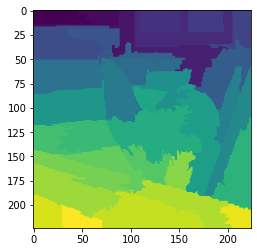

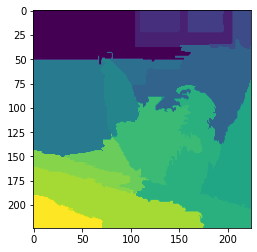

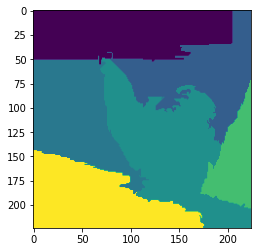

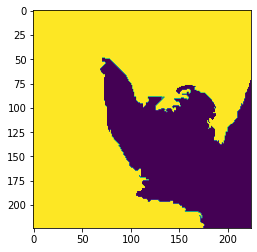

In [276]:
segment_mask,_ = selective_search(img,colour_space="hsv",scale=1,sim_threshold=0.95,sigma=0.8,min_size=300)
plt.imshow(segment_mask)
plt.figure()
segment_mask,_ = selective_search(img,colour_space="hsv",scale=20,sim_threshold=0.85,min_size=600)
plt.imshow(segment_mask)
plt.figure()
segment_mask,_ = selective_search(img,colour_space="hsv",scale=20,sim_threshold=0.75,min_size=1000)
plt.imshow(segment_mask)
plt.figure()
segment_mask,_ = selective_search(img,colour_space="hsv",scale=20,sim_threshold=0.65,min_size=1000)
plt.imshow(segment_mask)